In [1]:
import numpy as np
from scipy.linalg import eig
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os


In [12]:
def read_PEER(file_path=None):
    """
    Reads ground motion data from a PEER database file.

    Parameters:
    - file_path: str, the path to the PEER database file.

    Returns:
    - time_series: np.ndarray, the time series data (e.g., acceleration, velocity, displacement).
    - dt: float, the sampling time in seconds.
    - npts: int, the number of sampling points in the time series.
    """
    # Read numerical time series data
    with open(file_path, 'r') as fid:
        lines = fid.readlines()

    # Extract header information (line 4)
    header_line = lines[3]
    # Parse the NPTS and DT values robustly
    header_values = header_line.replace(",", "").replace("=", "").split()
    npts = int(header_values[1])
    dt = float(header_values[3])

    # Extract time series data (starting from line 5)
    time_series = []
    for line in lines[4:]:
        time_series.extend([float(x) for x in line.split() if x.strip()])
    
    time_series = np.array(time_series)

    return time_series, dt, npts


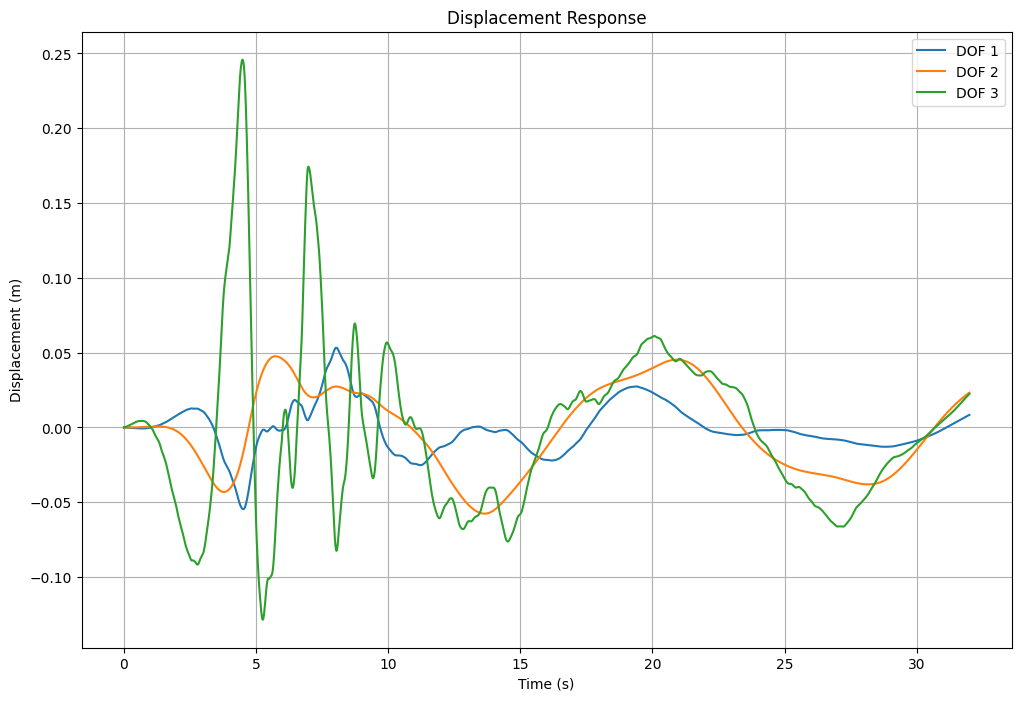

In [24]:

def newmark_solve(M, K, c, p, dt, d0, dDot0):
    # Newmark-beta method for solving SDOF systems
    npts = len(p)
    d = np.zeros(npts)
    dD = np.zeros(npts)
    dDD = np.zeros(npts)

    # Initial conditions
    d[0] = d0
    dD[0] = dDot0
    dDD[0] = (p[0] - c * dD[0] - K * d[0]) / M

    gamma = 0.5
    beta = 0.25

    a0 = 1 / (beta * dt**2)
    a1 = gamma / (beta * dt)
    a2 = 1 / (beta * dt)
    a3 = 1 / (2 * beta) - 1
    a4 = gamma / beta - 1
    a5 = dt / 2 * (gamma / beta - 2)

    Keff = M * a0 + c * a1 + K

    for i in range(1, npts):
        p_eff = p[i] + M * (a0 * d[i - 1] + a2 * dD[i - 1] + a3 * dDD[i - 1]) + c * (a1 * d[i - 1] + a4 * dD[i - 1] + a5 * dDD[i - 1])
        d[i] = p_eff / Keff
        dDD[i] = a0 * (d[i] - d[i - 1]) - a2 * dD[i - 1] - a3 * dDD[i - 1]
        dD[i] = dD[i - 1] + dt * ((1 - gamma) * dDD[i - 1] + gamma * dDD[i])

    return d, dD, dDD

# Parameters
g = 9.81
m = 1
k = 1
c = 1
nDof = 3

mMat = np.diag([4 * m, 2 * m, m])
kMat = np.array([
    [4 * k, -k, 0],
    [-k, 2 * k, -k],
    [0, -k, k]
])
cMat = np.array([
    [0.4 * c, -0.2 * c, 0],
    [-0.2 * c, 0.3 * c, -0.1 * c],
    [0, -0.1 * c, 0.1 * c]
])
iota = np.ones(nDof)

# Check classical damping
is_classical = np.allclose(cMat @ np.linalg.inv(mMat) @ kMat, kMat @ np.linalg.inv(mMat) @ cMat)

# Eigenvalue problem
wnSquared, phi = eig(kMat, mMat)  # Note the order: eigenvalues, then eigenvectors
wnSquared = np.real(wnSquared)  # Ensure eigenvalues are real (physical systems)
ind_comp = np.argsort(wnSquared)  # Sort indices based on eigenvalues
wns = np.sqrt(wnSquared[ind_comp])  # Sorted natural frequencies
phi = phi[:, ind_comp]  # Sort eigenvectors according to sorted eigenvalues

# Decoupled response
gam = [(phi[:, i].T @ mMat @ iota) / (phi[:, i].T @ mMat @ phi[:, i]) for i in range(nDof)]
Cnu = [phi[:, i].T @ cMat @ phi[:, i] for i in range(nDof)]
Mn = [phi[:, i].T @ mMat @ phi[:, i] for i in range(nDof)]

# Newmark linear acceleration
uDDg, dt, npts = read_PEER("../data/RSN1108_KOBE_KBU090.AT2")
t = np.arange(0, dt * npts, dt)

uDDg = uDDg * g
p = -m * uDDg

d0, dDot0 = 0, 0

results = []
for i in range(nDof):
    K = wns[i]**2
    zeta = (Cnu[i]) / (2 * wns[i] * Mn[i])
    c = 2 * zeta * wns[i]
    d, dD, dDD = newmark_solve(m, K, c, p, dt, d0, dDot0)
    results.append((d, dD, dDD))

# Combine modes
u = np.zeros((nDof, npts))
uD = np.zeros((nDof, npts))
uDD = np.zeros((nDof, npts))

for i, (d, dD, dDD) in enumerate(results):
    u += np.outer(phi[:, i], d)
    uD += np.outer(phi[:, i], dD)
    uDD += np.outer(phi[:, i], dDD)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t, u[0, :], label="DOF 1")
plt.plot(t, u[1, :], label="DOF 2")
plt.plot(t, u[2, :], label="DOF 3")
plt.title("Displacement Response")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (m)")
plt.legend()
plt.grid()
plt.show()

In [25]:
def newmark_solve(m, k, c, p, dt, u0, v0):
    """
    Newmark's Method (Linear Acceleration Method) for SDOF systems.

    Parameters:
    - m: Mass
    - k: Stiffness
    - c: Damping coefficient
    - p: External force (array)
    - dt: Time step
    - u0: Initial displacement
    - v0: Initial velocity

    Returns:
    - u: Displacement (array)
    - v: Velocity (array)
    - a: Acceleration (array)
    """
    num_points = len(p)

    # Initialize arrays for displacement, velocity, and acceleration
    u = np.zeros(num_points)
    v = np.zeros(num_points)
    a = np.zeros(num_points)
    
    # Initial conditions
    u[0] = u0
    v[0] = v0
    a[0] = (p[0] - c * v[0] - k * u[0]) / m

    # Constants for Newmark's method
    beta = 1 / 6
    gamma = 1 / 2
    
    a1 = m / (beta * dt**2) + gamma / (beta * dt) * c
    a2 = m / (beta * dt) + (gamma / beta - 1) * c
    a3 = (1 / (2 * beta) - 1) * m + dt * (gamma / (2 * beta) - 1) * c
    
    k_hat = k + a1

    # Iterate through time steps
    for i in range(num_points - 1):
        p_hat = p[i + 1] + a1 * u[i] + a2 * v[i] + a3 * a[i]
        u[i + 1] = p_hat / k_hat
        v[i + 1] = (gamma / (beta * dt)) * (u[i + 1] - u[i]) + (1 - gamma / beta) * v[i] + dt * (1 - gamma / (2 * beta)) * a[i]
        a[i + 1] = (u[i + 1] - u[i]) / (beta * dt**2) - v[i] / (beta * dt) - (1 / (2 * beta) - 1) * a[i]

    return u, v, a


<>:112: SyntaxWarning: invalid escape sequence '\d'
<>:112: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\1696440282.py:112: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\ddot{u}_g$ (m/s^2)")
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\1696440282.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  B_ng[i] = (-psi_pos[:, i].T @ mMat @ iota) / (


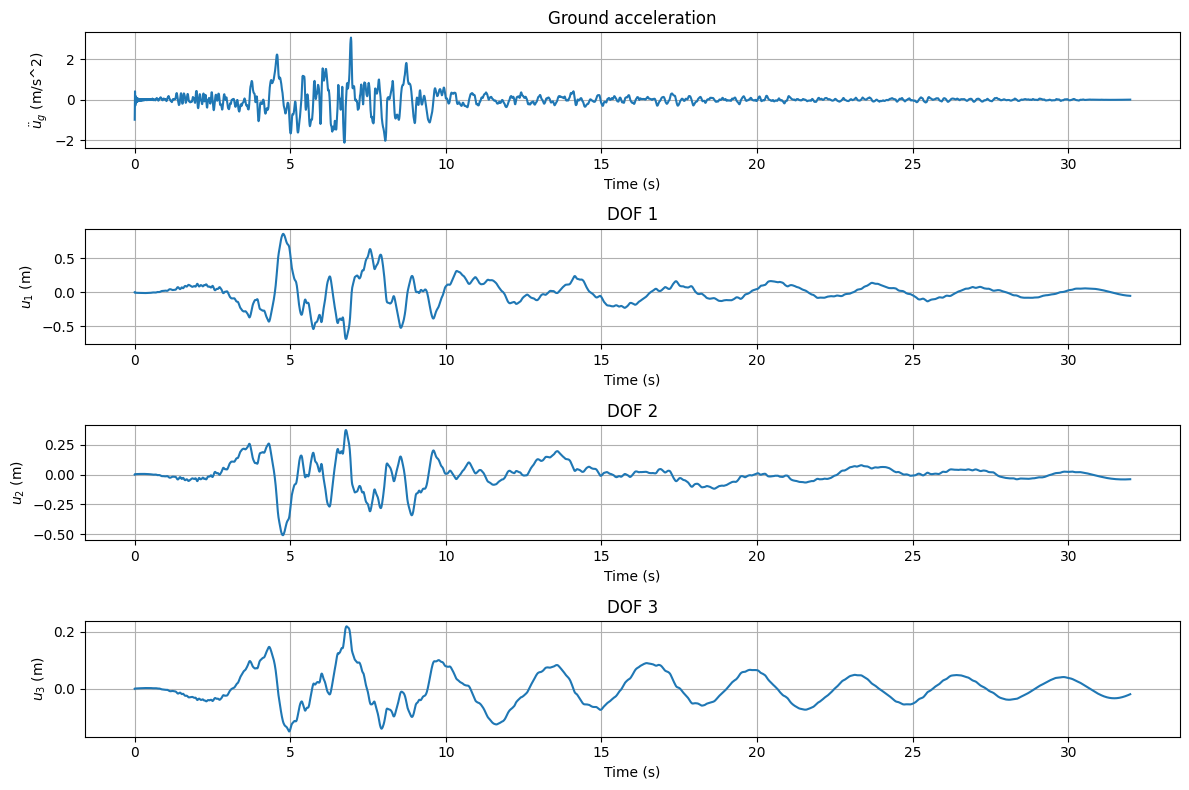

In [26]:
# Define system parameters
m = 1
k = 1
c = np.sqrt(k * m)

g = 9.81
nDof = 3

mMat = np.diag([m, m, m / 2])
kMat = np.array([
    [2 * k, -k, 0],
    [-k, 2 * k, -k],
    [0, -k, k]
])
cMat = np.diag([c, 0, 0])
iota = np.ones(nDof)

# Check for classical damping
is_classical = np.allclose(cMat @ np.linalg.inv(mMat) @ kMat, kMat @ np.linalg.inv(mMat) @ cMat)

# State-space matrices for eigenvalue problem
a = np.block([
    [np.zeros((nDof, nDof)), mMat],
    [mMat, cMat]
])
b = np.block([
    [-mMat, np.zeros((nDof, nDof))],
    [np.zeros((nDof, nDof)), kMat]
])

# Solve eigenvalue problem
lams, kappa = eig(b, -a)

# `lams` is already a 1D array of eigenvalues, so no need for np.diag
# Sort and extract positive eigenvalues
ind = np.argsort(np.imag(lams))  # Sorting based on imaginary part
lams = lams[ind]
kappa = kappa[:, ind]

# Separate positive and negative eigenvalues
lam_pos = []
lam_neg = []
psi_pos = []
psi_neg = []

for i in range(2 * nDof):
    imag_part = np.imag(lams[i])
    if imag_part > 0:
        lam_pos.append(lams[i])
        psi_pos.append(kappa[nDof:, i])
    else:
        lam_neg.append(lams[i])
        psi_neg.append(kappa[nDof:, i])

lam_pos = np.array(lam_pos)
psi_pos = np.array(psi_pos).T


wns = np.abs(lam_pos)
zetas = -np.real(lam_pos) / np.abs(lam_pos)
wds = np.imag(lam_pos)

# Compute modal participation factors and modal properties
psi_pos = np.array(psi_pos).T
B_ng = np.zeros(nDof)
beta_ng = np.zeros((nDof, nDof))
gamma_ng = np.zeros((nDof, nDof))
alpha_ng = np.zeros((nDof, nDof))

for i in range(nDof):
    B_ng[i] = (-psi_pos[:, i].T @ mMat @ iota) / (
        2 * lam_pos[i] * psi_pos[:, i].T @ mMat @ psi_pos[:, i] + psi_pos[:, i].T @ cMat @ psi_pos[:, i]
    )
    beta_ng[:, i] = np.real(2 * B_ng[i] * psi_pos[:, i])
    gamma_ng[:, i] = np.imag(2 * B_ng[i] * psi_pos[:, i])
    alpha_ng[:, i] = zetas[i] * beta_ng[:, i] - np.sqrt(1 - zetas[i]**2) * gamma_ng[:, i]

# Newmark linear acceleration method
uDDg, dt, npts = read_PEER("../data/RSN1108_KOBE_KBU090.AT2")
t = np.linspace(0, dt * (npts - 1), npts)
uDDg = uDDg * g
p = -m * uDDg

d0 = 0
dDot0 = 0

# Solve for each mode
d = np.zeros((npts, nDof))
dD = np.zeros((npts, nDof))
dDD = np.zeros((npts, nDof))

for i in range(nDof):
    k_mode = wns[i]**2
    c_mode = zetas[i] * 2 * wns[i]
    d[:, i], dD[:, i], dDD[:, i] = newmark_solve(m, k_mode, c_mode, p, dt, d0, dDot0)

# Combine modal responses
u = np.zeros((nDof, npts))

for i in range(nDof):
    for j in range(npts):
        ui = alpha_ng[:, i] * wns[i] * d[j, i] + beta_ng[:, i] * dD[j, i]
        u[:, j] += ui

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, uDDg)
plt.title("Ground acceleration")
plt.xlabel("Time (s)")
plt.ylabel("$\ddot{u}_g$ (m/s^2)")
plt.grid()

for i in range(nDof):
    plt.subplot(4, 1, i + 2)
    plt.plot(t, u[i, :])
    plt.title(f"DOF {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel(f"$u_{i + 1}$ (m)")
    plt.grid()

plt.tight_layout()
plt.show()


<>:124: SyntaxWarning: invalid escape sequence '\d'
<>:124: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\2369088248.py:124: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\ddot{u}_g$ (m/s^2)")
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\2369088248.py:23: RuntimeWarning: overflow encountered in scalar multiply
  p_eff = p[i] + a1 * dD[i - 1] + a2 * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\2369088248.py:26: RuntimeWarning: overflow encountered in scalar divide
  dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\2369088248.py:26: RuntimeWarning: invalid value encountered in scalar subtract
  dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\2369088248.py:26: RuntimeWarning: overflow encountered 

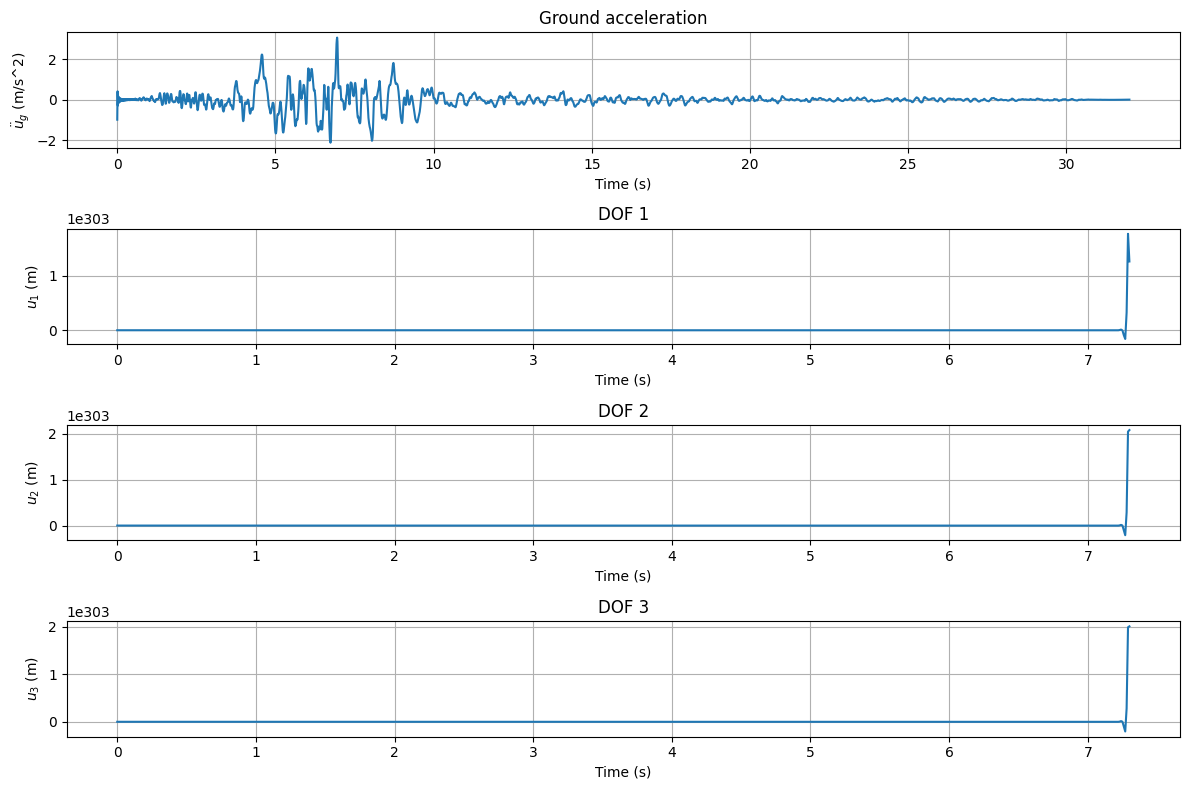

In [27]:
# Define Newmark's Method

def newmarkSDOF(m, k, c, p, dt, d0, dDot0):
    npts = len(p)
    d = np.zeros(npts)
    dD = np.zeros(npts)
    dDD = np.zeros(npts)

    # Initial conditions
    d[0] = d0
    dD[0] = dDot0
    dDD[0] = (p[0] - c * dD[0] - k * d[0]) / m

    # Newmark coefficients
    beta = 1 / 6
    gamma = 1 / 2

    a0 = m / (beta * dt**2) + gamma / (beta * dt) * c + k
    a1 = m / (beta * dt) + gamma / beta * c
    a2 = m / (2 * beta) - c * dt * (gamma / (2 * beta) - 1)

    for i in range(1, npts):
        p_eff = p[i] + a1 * dD[i - 1] + a2 * dDD[i - 1]
        d[i] = p_eff / a0
        dD[i] = gamma / (beta * dt) * (d[i] - d[i - 1]) - (gamma / beta - 1) * dD[i - 1] - dt * (gamma / (2 * beta) - 1) * dDD[i - 1]
        dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]

    return d, dD, dDD

# Define parameters
m = 1
k = 1
c = 1

g = 9.81
nDof = 3

mMat = np.diag([4 * m, 2 * m, m])
kMat = np.array([
    [4 * k, -k, 0],
    [-k, 2 * k, -k],
    [0, -k, k]
])
cMat = np.array([
    [0.4 * c, -0.2 * c, 0],
    [-0.2 * c, 0.3 * c, -0.1 * c],
    [0, -0.1 * c, 0.1 * c]
])
iota = np.ones(nDof)

# Check for classical damping
is_classical = np.allclose(cMat @ np.linalg.inv(mMat) @ kMat, kMat @ np.linalg.inv(mMat) @ cMat)

# Eigenvalue problem
wnSquared, phi = np.linalg.eig(np.linalg.inv(mMat) @ kMat)
wnSquared = np.real(wnSquared)
ind = np.argsort(wnSquared)
wnSquared = wnSquared[ind]
wns = np.sqrt(wnSquared)
phi = phi[:, ind]

# Decoupled response
Cnu = []
Mn = []
gam = []

for i in range(nDof):
    gam.append((phi[:, i].T @ mMat @ iota) / (phi[:, i].T @ mMat @ phi[:, i]))
    Cnu.append(phi[:, i].T @ cMat @ phi[:, i])
    Mn.append(phi[:, i].T @ mMat @ phi[:, i])

# Read ground motion data
def read_PEER(file_path):
    with open(file_path, 'r') as fid:
        lines = fid.readlines()
    time_series = []
    for line in lines[4:]:
        time_series.extend([float(x) for x in line.split()])
    time_series = np.array(time_series)
    dt = float(lines[3].split('=')[2].split()[0])
    npts = len(time_series)
    return time_series, dt, npts

uDDg, dt, npts = read_PEER("../data/RSN1108_KOBE_KBU090.AT2")
t = np.arange(0, dt * npts, dt)
uDDg = uDDg * g
p = -m * uDDg

d0 = 0
dDot0 = 0

# Modal analysis
K = wns**2
zeta = [1 / (2 * wns[i]) * Cnu[i] / Mn[i] for i in range(nDof)]
c = [zeta[i] * 2 * wns[i] for i in range(nDof)]

d, dD, dDD = [], [], []
q, qD, qDD = [], [], []

for i in range(nDof):
    d_i, dD_i, dDD_i = newmarkSDOF(m, K[i], c[i], p, dt, d0, dDot0)
    d.append(d_i)
    dD.append(dD_i)
    dDD.append(dDD_i)
    q.append(gam[i] * d_i)
    qD.append(gam[i] * dD_i)
    qDD.append(gam[i] * dDD_i)

# Combine modal responses
u = np.zeros((nDof, npts))

for i in range(nDof):
    for j in range(npts):
        ui = phi[:, i] * q[i][j]
        u[:, j] += ui

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, uDDg)
plt.title("Ground acceleration")
plt.xlabel("Time (s)")
plt.ylabel("$\ddot{u}_g$ (m/s^2)")
plt.grid()

for i in range(nDof):
    plt.subplot(4, 1, i + 2)
    plt.plot(t, u[i, :])
    plt.title(f"DOF {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel(f"$u_{i + 1}$ (m)")
    plt.grid()

plt.tight_layout()
plt.show()


<>:141: SyntaxWarning: invalid escape sequence '\d'
<>:141: SyntaxWarning: invalid escape sequence '\d'
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\353391913.py:141: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\ddot{u}_g$ (m/s^2)")
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\353391913.py:21: RuntimeWarning: overflow encountered in scalar multiply
  p_eff = p[i] + a1 * dD[i - 1] + a2 * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\353391913.py:24: RuntimeWarning: overflow encountered in scalar divide
  dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\353391913.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]
C:\Users\jxu20\AppData\Local\Temp\ipykernel_12872\353391913.py:24: RuntimeWarning: overflow encountered in sc

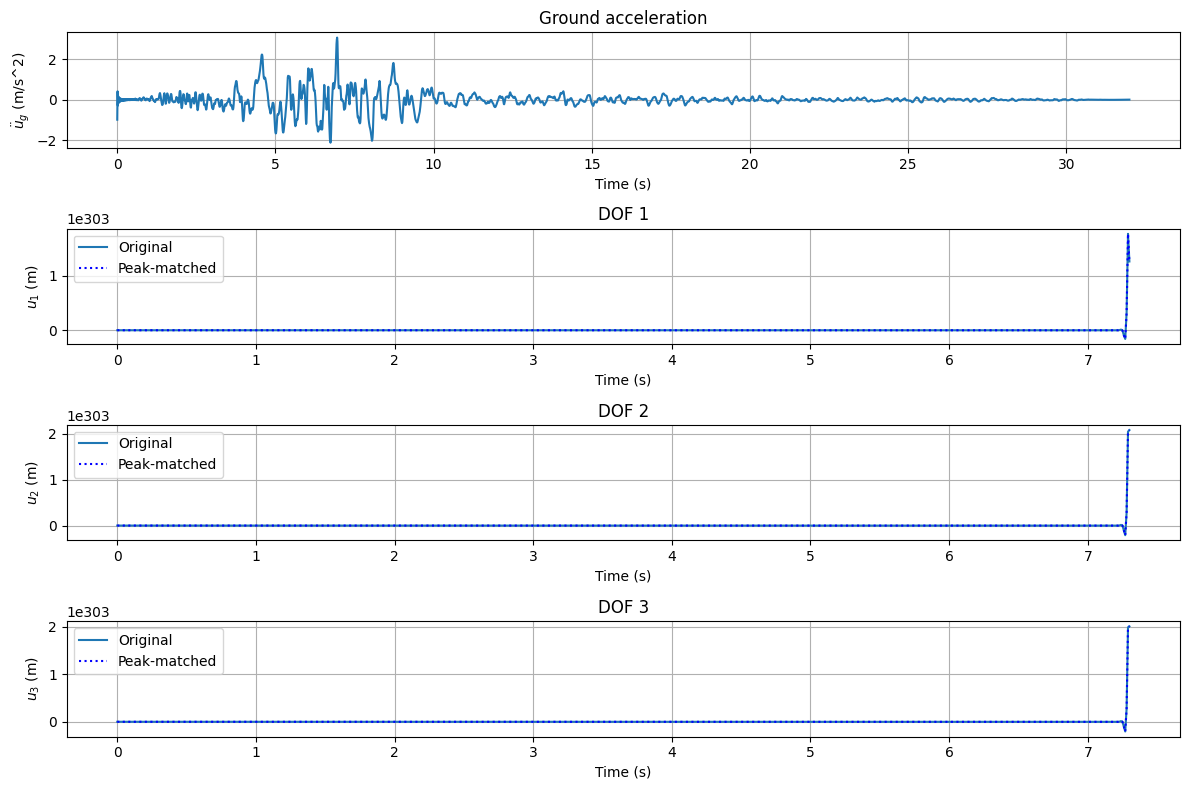

In [23]:
def newmarkSDOF(m, k, c, p, dt, d0, dDot0):
    npts = len(p)
    d = np.zeros(npts)
    dD = np.zeros(npts)
    dDD = np.zeros(npts)

    # Initial conditions
    d[0] = d0
    dD[0] = dDot0
    dDD[0] = (p[0] - c * dD[0] - k * d[0]) / m

    # Newmark coefficients
    beta = 1 / 6
    gamma = 1 / 2

    a0 = m / (beta * dt**2) + gamma / (beta * dt) * c + k
    a1 = m / (beta * dt) + gamma / beta * c
    a2 = m / (2 * beta) - c * dt * (gamma / (2 * beta) - 1)

    for i in range(1, npts):
        p_eff = p[i] + a1 * dD[i - 1] + a2 * dDD[i - 1]
        d[i] = p_eff / a0
        dD[i] = gamma / (beta * dt) * (d[i] - d[i - 1]) - (gamma / beta - 1) * dD[i - 1] - dt * (gamma / (2 * beta) - 1) * dDD[i - 1]
        dDD[i] = (d[i] - d[i - 1]) / (beta * dt**2) - dD[i - 1] / (beta * dt) - (1 / (2 * beta) - 1) * dDD[i - 1]

    return d, dD, dDD

# Define parameters
m = 1
k = 1
c = 1

g = 9.81
nDof = 3

mMat = np.diag([4 * m, 2 * m, m])
kMat = np.array([
    [4 * k, -k, 0],
    [-k, 2 * k, -k],
    [0, -k, k]
])
cMat = np.array([
    [0.4 * c, -0.2 * c, 0],
    [-0.2 * c, 0.3 * c, -0.1 * c],
    [0, -0.1 * c, 0.1 * c]
])
iota = np.ones(nDof)

# Check for classical damping
is_classical = np.allclose(cMat @ np.linalg.inv(mMat) @ kMat, kMat @ np.linalg.inv(mMat) @ cMat)

# Eigenvalue problem
wnSquared, phi = np.linalg.eig(np.linalg.inv(mMat) @ kMat)
wnSquared = np.real(wnSquared)
ind = np.argsort(wnSquared)
wnSquared = wnSquared[ind]
wns = np.sqrt(wnSquared)
phi = phi[:, ind]

# Decoupled response
Cnu = []
Mn = []
gam = []

for i in range(nDof):
    gam.append((phi[:, i].T @ mMat @ iota) / (phi[:, i].T @ mMat @ phi[:, i]))
    Cnu.append(phi[:, i].T @ cMat @ phi[:, i])
    Mn.append(phi[:, i].T @ mMat @ phi[:, i])

# Read ground motion data
def read_PEER(file_path):
    with open(file_path, 'r') as fid:
        lines = fid.readlines()
    time_series = []
    for line in lines[4:]:
        time_series.extend([float(x) for x in line.split()])
    time_series = np.array(time_series)
    dt = float(lines[3].split('=')[2].split()[0])
    npts = len(time_series)
    return time_series, dt, npts

uDDg, dt, npts = read_PEER("../data/RSN1108_KOBE_KBU090.AT2")
t = np.arange(0, dt * npts, dt)
uDDg = uDDg * g
p = -m * uDDg

d0 = 0
dDot0 = 0

# Modal analysis
K = wns**2
zeta = [1 / (2 * wns[i]) * Cnu[i] / Mn[i] for i in range(nDof)]
c = [zeta[i] * 2 * wns[i] for i in range(nDof)]

d, dD, dDD = [], [], []
q, qD, qDD = [], [], []

for i in range(nDof):
    d_i, dD_i, dDD_i = newmarkSDOF(m, K[i], c[i], p, dt, d0, dDot0)
    d.append(d_i)
    dD.append(dD_i)
    dDD.append(dDD_i)
    q.append(gam[i] * d_i)
    qD.append(gam[i] * dD_i)
    qDD.append(gam[i] * dDD_i)

# Combine modal responses
u = np.zeros((nDof, npts))

for i in range(nDof):
    for j in range(npts):
        ui = phi[:, i] * q[i][j]
        u[:, j] += ui

# Approximate new diagonal values
Cn = phi.T @ cMat @ phi
Cdn = []

for n in range(nDof):
    num = sum(Cn[n, m] * qD[m][np.argmax(np.abs(qD[m]))] for m in range(nDof))
    Cdn.append(num / qD[n][np.argmax(np.abs(qD[n]))])

Cd = np.diag(Cdn)
CPrime = np.linalg.inv(phi).T @ Cd @ np.linalg.inv(phi)

# Peak-matched analysis
ud = np.zeros((nDof, npts))

for i in range(nDof):
    for j in range(npts):
        uid = phi[:, i] * q[i][j]
        ud[:, j] += uid

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, uDDg)
plt.title("Ground acceleration")
plt.xlabel("Time (s)")
plt.ylabel("$\ddot{u}_g$ (m/s^2)")
plt.grid()

for i in range(nDof):
    plt.subplot(4, 1, i + 2)
    plt.plot(t, u[i, :], label="Original")
    plt.plot(t, ud[i, :], "b:", label="Peak-matched")
    plt.title(f"DOF {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel(f"$u_{i + 1}$ (m)")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
